# Routine Activity Theory and Street Crime

The idea behind routine activity theory (RAT) is that if the frequency of convergence between offenders, guardians, and targets increases, crime rates may increase even if the absolute number of motivated offenders remains constant. In other words, as individuals spend more time away from home, crime rates increase. We'll explore RAT by simulating many `Citizens` inside of a `CrimeWorld`.

In [333]:
from __future__ import print_function, division

import random
import thinkplot
import numpy as np
from Cell2D import Cell2D, Cell2DViewer
from thinkstats2 import Cdf
from thinkstats2 import RandomSeed
import matplotlib.pyplot as plt
from matplotlib import rc
rc('animation', html='html5')

In our simulated world, `CrimeWorld`, there are two types of agents: police officers and regular citizens. Regular citizens can have a variety of roles: some are offenders (agents who commit crimes), some are guardians (agents who prevent crimes), and some are targets (agents against whom crimes are committed).

The `Citizen` class represents every type of citizen, including police officers. For the purposes of the simulation, the `Citizen` class contains properties of all types of agents. More specifically, police officers are just citizens with the `isPopo` boolean set to `true`; offenders are just citizens who use the `decideToOffend`, `pickChump`, and `rob` functions; and targets are just citizens who use the `getRobbed` function.

A variety of factors affect an offender's decision to commit a crime. Consider a bunch of agents at a single node; some might be police, some might be guardians, and some might be offenders trying to find a guardian to make into a target. The first factor the offenders must consider is whether there are police at the node. The presence of a police officer is an absolute dealbreaker; no offender will commit a crime if they know someone is nearby who can catch them and stick them in jail for it.

If there are no police officers, however, the second factor the offenders must consider is the guardianship of other agents present; we'll call this variable `G`.

`G = (N`<sub>agents</sub>` - 2) + P`

`G` depends on two other variables. `N`<sub>agents</sub> is the total number of agents present at a given node, and we subtract 2 to account for the offender and their potential target. `P` is a randomly selected number between -2 and 2 that represents the offender's perception of the capability of the guardians who are present.

If `G < 1`, the offender determines that there are not capable guardians present, so they should commit the crime.

If `G == 1`, the offender isn't sure if there are capable guardians present, so they make a random decision to commit the crime.

And finally, if `G > 1`, the offender determines that there are capable guardians present and they should not commit the crime.

Now, let's assume `G <= 1` and the offender has decided to commit the crime. Which agent should the offender offend? The offender must consider the suitability of the potential targets in the node, a variable we'll call `S`.

`S = (W`<sub>target</sub>` - W`<sub>offender</sub>`) + P`

`S` depends on several other variables. `W`<sub>target</sub> is the wealth of the potential target and `W`<sub>offender</sub> is the wealth of the offender. And like our equation for `G`, `P` represents a randomly selected number, this time between -1 and 1, which represents the offender's perception of the wealth of the target.

If `S >= 0`, the offender determines that the target is suitably wealthy and robs them.

If `S < 0`, the offender determines that the target is not suitably wealthy, so they move on to the next potential target in the node.

We define the equations for finding `G` and `S` as `decideToOffend` and `pickChump`, respectively.

In [63]:
class Citizen():
    """
    Represents a citizen in CrimeWorld.
    Average time away from home: 30% (7.7 hours)
    To be increased by 10%
    """
  
    # TODO: Add time away from home proportion to params
    def __init__(self, loc, wealth, time_from_home):
        self.wealth = wealth
        self.motivation = random.randint(0,10)
        self.loc = loc
        self.isPopo = False
        self.timeAway = 0
        self.isHome = False
        self.timeAtHome = 0
        self.time_from_home = 24*time_from_home
        

    def step(self):
        self.wealth += 5
        if (self.isHome):
            if (self.timeAtHome >= 24 - self.time_from_home):
                shouldGoHome = random.randint(0, 10)
                if (shouldGoHome <= 3):
                    self.isHome = False # Leave home
                    self.timeAtHome = 0
                else:
                    self.timeAtHome += 1
            else:
                self.timeAtHome += 1
        else:
            if (self.timeAway >= self.time_from_home):
                self.isHome = True # Go home
                self.timeAway = 0
            else:
                self.timeAway += 1
                directions = [[0,5], [0,-5], [5,0], [-5,0]]
                #TODO: don't flee seattle
                index = np.random.randint(4)
                self.loc = np.add(self.loc, directions[index])

                if (self.timeAway % 5 == 0): #motivation is currently not in use
                    self.motivation += 1

    def getRobbed(self):
        self.wealth -= 1

    def rob(self):
        self.wealth += 1

    def decideToOffend(self, agents):
        for agent in agents:
            if agent.isPopo:
                return False
        return True
  
    def setHome(self, state):
        self.isHome = state

        capability = random.randint(-2, 2)
        G = len(agents) - 2 + capability

        if G > 1:
            return False
        elif G == 1:
            p = random.choice([True, False])
            return p

        return True
    
    def setPopo(self, state):
        self.isPopo = state    

    def pickChump(self, agents):
        if (agents != []):
            return max(agents, key= lambda x: x.wealth)

Now, we need to create the world that all these citizens live in. `CrimeWorld` is based on `Cell2D` and LA's real-world properties. In `CrimeWorld`, we keep track of the locations of all citizens and crimes in an array, where each cell represents the location of a street intersection.

In [64]:
class CrimeWorld(Cell2D):
    """
    Represents the world in which our simulation takes place.
    LA:
    60627 street intersections
    Seattle:
        16035 nodes
        1000 civilians
        200 police
        20% of civilians are ready to commit a crime
    """

    def __init__(self, n, **params):
        """
        Initializes the attributes.
  
        n: number of rows and columns
        params: dictionary of parameters
            -num_citizens
            -num_police
            -prop_criminals
        """
        self.params = params
        self.array = np.zeros((n, n), np.float)
        self.make_agents(n)
        self.n = n
        self.agent_count_seq = [] # track variables
        self.total_robs = 0
        self.rob_count_seq = []
  
    def make_locs(self, n, m):
        """
        Makes array where each row is an index in an `n` by `m` grid.
    
        n: int number of rows
        m: int number of cols
    
        returns: NumPy array
        """
        left = np.repeat(np.arange(m), n)
        right = np.tile(np.arange(n), m)
        return np.transpose([left, right])

    def make_agents(self, n):
        """Makes the agents."""
  
        # determine where the agents start and generate locations
        # n, m = self.params.get('starting_box', self.array.shape)
        locs = self.make_locs(n, n)
        np.random.shuffle(locs)
  
        # make the agents
        num_citizens = self.params.get('num_citizens', 1000)
        num_police = self.params.get('num_police', 200)
        time_from_home = self.params.get('time_from_home', 0.3)
        self.citizens = [Citizen(locs[i], 5, time_from_home = time_from_home) #everyone starts out with wealth of 5
                            for i in np.random.choice(range(len(locs)), num_citizens)]
#         for citizen in self.citizens:
#             self.array[citizen.loc] += 1
        for citizen in random.sample(self.citizens, num_police):
            citizen.setPopo(True)  # set police
        # self.occupied = set(citizen.loc for citizen in self.citizens) # keep track of occupied cells
  
    def step(self):
        num_citizens = float(self.params.get('num_citizens', 1000))
        prop_criminals = self.params.get('prop_criminals', 0.2)
        for citizen in self.citizens:
            citizen.step()    
        for potential_criminal in random.sample(self.citizens, int(prop_criminals * num_citizens)):
            citizens_in_node = [x for x in self.citizens if np.array_equal(x.loc,potential_criminal.loc) and not x.isHome]
            if potential_criminal.decideToOffend(citizens_in_node):
                target = potential_criminal.pickChump(citizens_in_node)
                if (target != None):
                    potential_criminal.rob()
                    target.getRobbed()
#                 self.array[target.loc] += 1
                    self.total_robs += 1
    
        self.rob_count_seq.append(self.total_robs)

We can view the results of our simulation using the `CrimeWorldViewer` below.

In [65]:
class CrimeWorldViewer(Cell2DViewer):
    """Generates visualization and animation of Sugarscape."""

    cmap = plt.get_cmap('viridis_r')

    options = dict(interpolation='none', alpha=0.8,
                   vmin=0, vmax=9)

    def draw(self, grid=False):
        #TODO: draw robberies
        """Draws the array and any other elements.

        grid: boolean, whether to draw grid lines
        """
        self.draw_array(self.viewee.array, origin='lower')
        self.draw_agents()

    def draw_agents(self):
        """Plots the agents.
        """
        xs, ys = self.get_coords()
        self.points = plt.plot(xs, ys, '.', color='red')[0]
        plt.show()

    def animate_func(self, i):
        """Draws one frame of the animation."""
        Cell2DViewer.animate_func(self, i)
        xs, ys = self.get_coords()
        self.points.set_data(np.array([xs, ys]))
        return self.im, self.points

    def get_coords(self):
        """Gets the coordinates of the agents.

        Transforms from (row, col) to (x, y).

        returns: tuple of sequences, (xs, ys)
        """
        agents = self.viewee.citizens
        rows, cols = np.transpose([agent.loc for agent in agents])
        xs = cols + 0.5
        ys = rows + 0.5
        return xs, ys

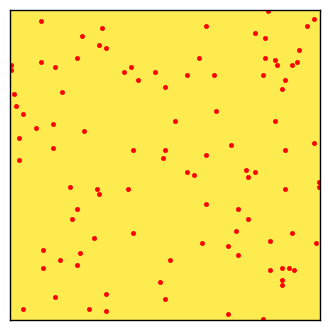

In [66]:
RandomSeed(17)
env = CrimeWorld(127, num_citizens=100, prop_criminals=0.2, num_police=15, time_from_home = 0.3)
viewer = CrimeWorldViewer(env)
viewer.draw()


In [67]:
# anim = viewer.animate(frames=500)
# anim
thinkplot.plot(env.rob_count_seq)

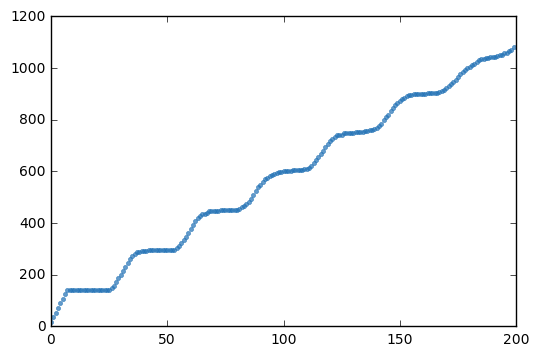

In [68]:
for i in range(200):
    env.step()

thinkplot.plot(env.rob_count_seq, style='.')
plt.show()

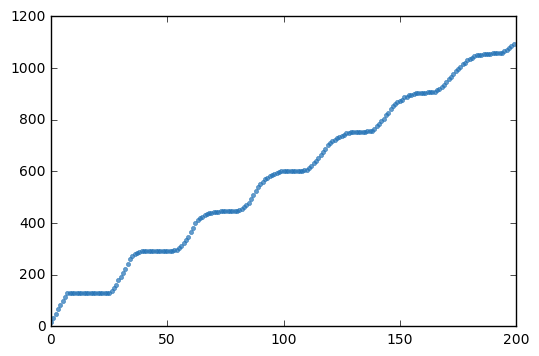

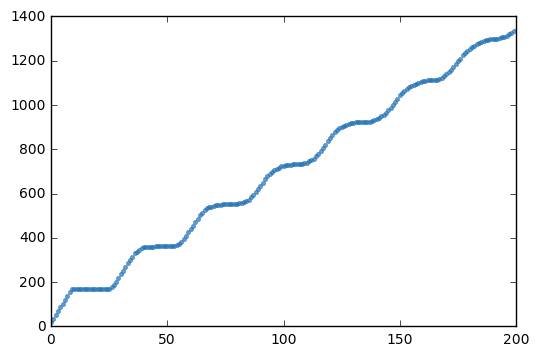

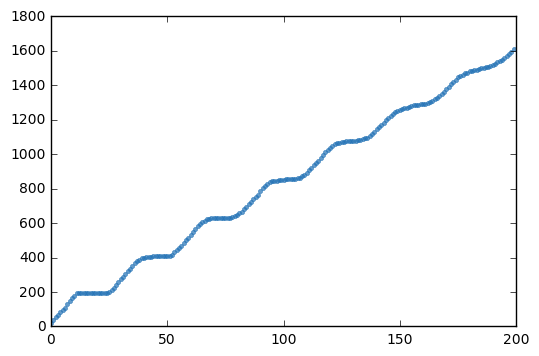

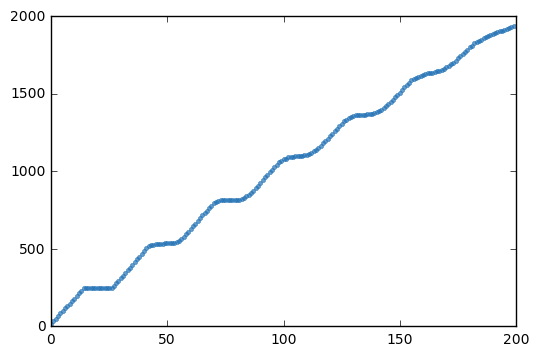

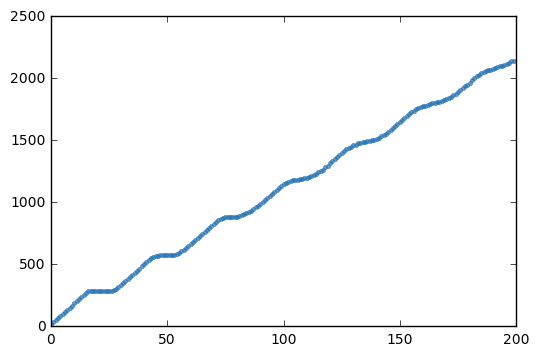

In [70]:
times_from_home = [0.3, 0.4, 0.5, 0.6, 0.7]
for time in times_from_home:
    env = CrimeWorld(127, num_citizens=100, prop_criminals=0.2, num_police=15, time_from_home = time)
    viewer = CrimeWorldViewer(env)
    thinkplot.plot(env.rob_count_seq)
    for i in range(200):
        env.step()

    thinkplot.plot(env.rob_count_seq, style='.')
    plt.show()